In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_labels.txt", 
                     sep="\t", header=None)
labels['id'] = labels.index
labels.columns = ['label', 'id']
labels.head()

,label,id
0,6,0
1,4,1
2,3,2
3,6,3
4,5,4


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_672678/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{6: 0, 4: 1, 3: 2, 5: 3, 2: 4, 1: 5, 0: 6, 7: 7}

## Exploring node features

In [5]:
from sklearn.metrics.pairwise import *

features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_features.txt", sep="\s+", header=None)
features['id'] = features.index
features

,0,1,2,3,4,5,6,7,8,9,...,736,737,738,739,740,741,742,743,744,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,1
2,0,1,0,0,0,0,1,1,1,0,...,0,0,0,1,0,1,0,0,1,2
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,1,0,1,1,0,3
4,0,1,0,0,1,0,1,1,0,0,...,0,0,0,1,1,1,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,1,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,7645
7646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7646
7647,0,1,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,7647
7648,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,7648


In [6]:
gcc_edges = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/amazon_photo_GC.edge")

# There are 7535 nodes and more features so we needed to map it somehow
# gcc_edges = np.loadtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/amazon_photo/amazon_photo.edge")
gcc_edges_idx = np.unique(gcc_edges.flatten()).astype(int)
gcc_edges_idx.sort()
gcc_edges_idx

array([   0,    1,    2, ..., 7647, 7648, 7649])

In [7]:
data = features.merge(labels, on="id")
data = data[data.id.isin(gcc_edges_idx)] # Optional: only take GCC
data

,0,1,2,3,4,5,6,7,8,9,...,737,738,739,740,741,742,743,744,id,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,6
1,0,0,0,0,0,0,1,1,1,0,...,0,0,1,0,0,0,0,0,1,4
2,0,1,0,0,0,0,1,1,1,0,...,0,0,1,0,1,0,0,1,2,3
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,1,0,1,1,0,3,6
4,0,1,0,0,1,0,1,1,0,0,...,0,0,1,1,1,0,1,0,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7645,1,1,0,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,7645,2
7646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7646,2
7647,0,1,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,7647,1
7648,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,7648,2


## Dimensional reduction of the nodes' features using UMAP

In [8]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["id", "label"], axis=1).values
y = data['label'].values

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 1, 1, 0],
        [0, 1, 0, ..., 0, 1, 0]]),
 array([6, 4, 3, 6, 5]))

In [9]:
np.mean(X.sum(axis=1))

260.4752237211166

In [9]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

CPU times: user 33.8 s, sys: 2.3 s, total: 36.1 s
Wall time: 33.8 s


(7487, 2)

Text(0.5, 1.0, 'UMAP dim=2')

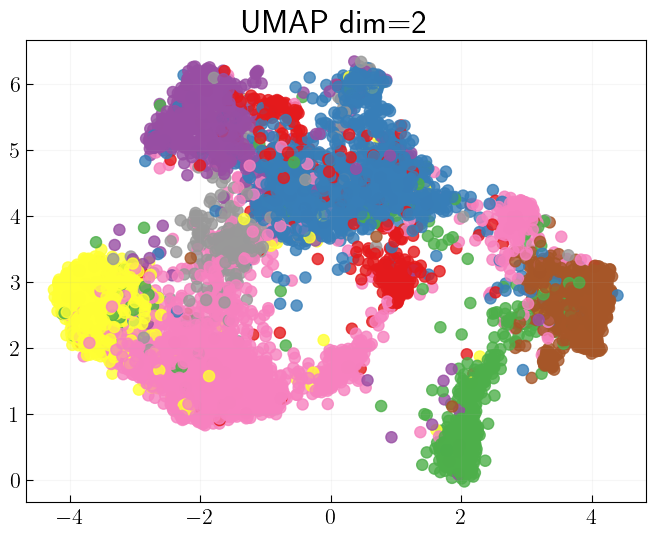

In [10]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [11]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

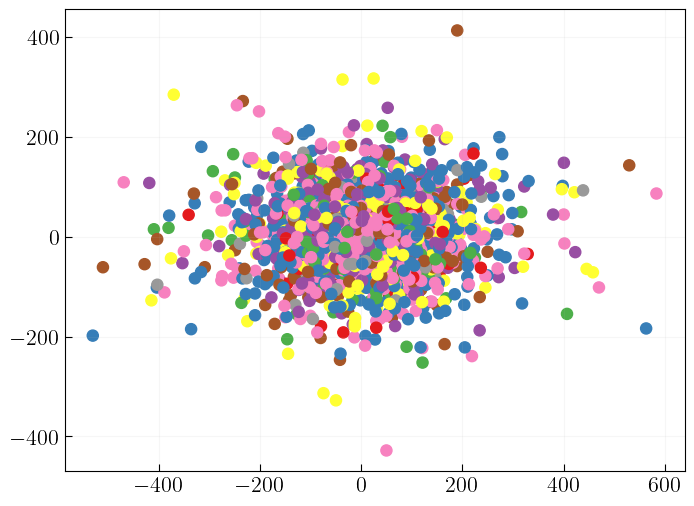

In [12]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [13]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

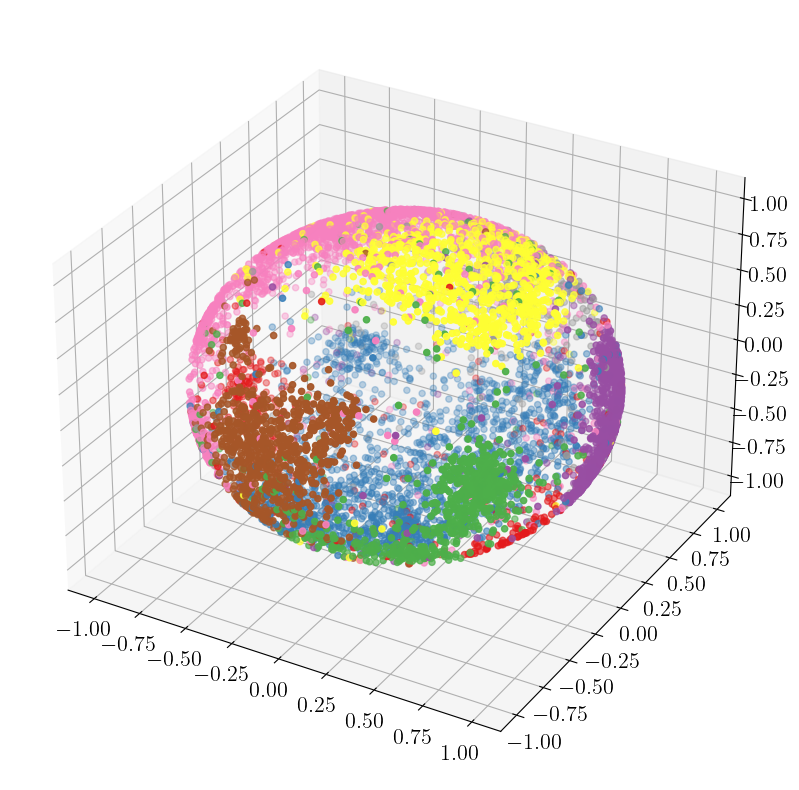

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [15]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [16]:
idx = data['id'].values
idx
# np.c_[idx, vectors]

array([   0,    1,    2, ..., 7647, 7648, 7649])

In [17]:
vectors

array([[-0.05373893,  0.9615439 ,  0.26934257],
       [ 0.05448244,  0.04399066,  0.99754524],
       [ 0.8709424 ,  0.30572402,  0.38469753],
       ...,
       [ 0.05074319, -0.03698831, -0.99802655],
       [ 0.8631006 , -0.49672374, -0.09122933],
       [ 0.9951889 ,  0.04090469,  0.08902723]], dtype=float32)

In [18]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/amazon_photo/umap/only_gcc/umap_amazon_photo_spherical_positions_only_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [19]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/amazon_photo/umap/all/umap_amazon_photo_spherical_positions_all.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [20]:
# F-Mercator

# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/umap_amazon_photo_spherical_positions_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [31]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 1min 21s, sys: 2.39 s, total: 1min 23s
Wall time: 1min 38s


100%|██████████| 7487/7487 [35:59<00:00,  3.47it/s] 


The best Z-axis rotation angle:  5.129130863003743


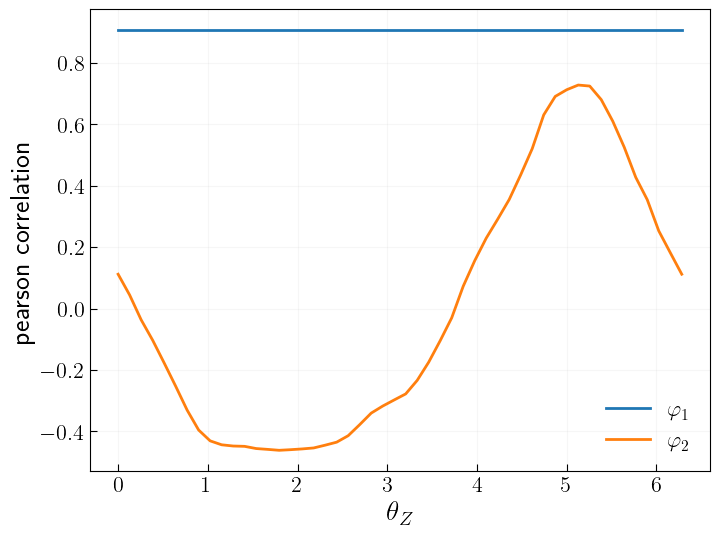

In [32]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2, )

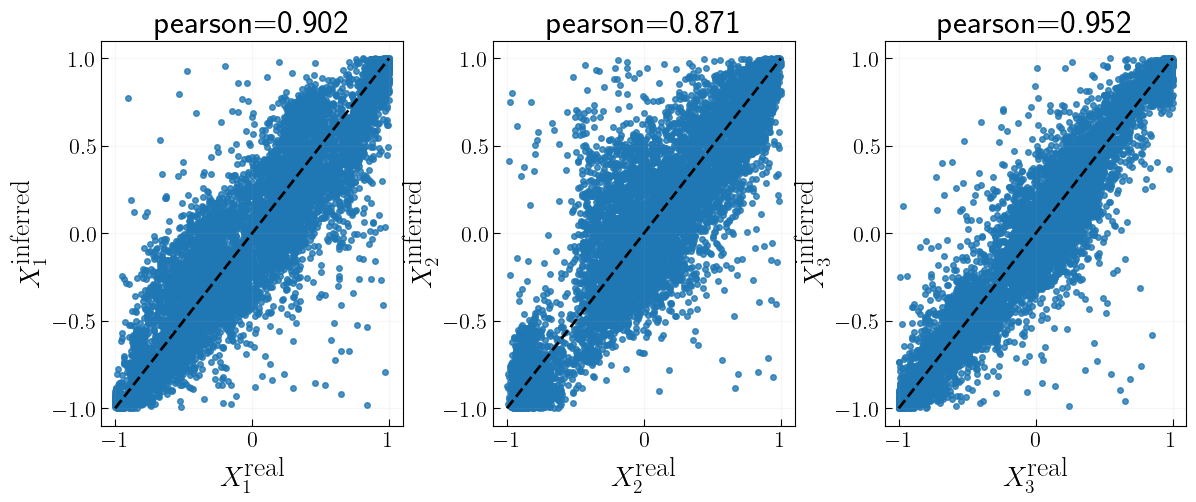

In [33]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)

## Convert to .x, .y, .tx, .ty, .ally, allx format

From https://github.com/NIRVANALAN/gcn_analysis/blob/master/notebook/Plantenoid%20Citation%20Data%20Format%20Transformation.ipynb

In [25]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [108]:
import scipy.sparse as sp
from scipy.sparse.linalg.eigen.arpack import eigsh
import sys

new_features = sp.csr_matrix(data.values[:, :-2], dtype=np.float32)
new_features

<7535x745 sparse matrix of type '<class 'numpy.float32'>'
	with 1957847 stored elements in Compressed Sparse Row format>

In [115]:
new_labels = encode_onehot(data['label'].values)

# build graph
idx = np.array(data['id'].values, dtype=np.int32)
idx_map = {j: i for i, j in enumerate(idx)}


new_edges_unordered = np.genfromtxt("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/amazon_photo/amazon_photo.edge",
                                    dtype=np.int32)

new_edges = np.array(list(map(idx_map.get, new_edges_unordered.flatten())),
                     dtype=np.int32).reshape(new_edges_unordered.shape)

adj = sp.coo_matrix((np.ones(new_edges.shape[0]), (new_edges[:, 0], new_edges[:, 1])),
                     shape=(new_labels.shape[0], new_labels.shape[0]),
                     dtype=np.float32)

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
idx_train = range(160) 
idx_val = range(200, 500)
idx_test = range(500, 6500)

```
ind.dataset_str.x => the feature vectors of the training instances as scipy.sparse.csr.csr_matrix object;
ind.dataset_str.tx => the feature vectors of the test instances as scipy.sparse.csr.csr_matrix object;
ind.dataset_str.allx => the feature vectors of both labeled and unlabeled training instances
    (a superset of ind.dataset_str.x) as scipy.sparse.csr.csr_matrix object;
ind.dataset_str.y => the one-hot labels of the labeled training instances as numpy.ndarray object;
ind.dataset_str.ty => the one-hot labels of the test instances as numpy.ndarray object;
ind.dataset_str.ally => the labels for instances in ind.dataset_str.allx as numpy.ndarray object;
ind.dataset_str.graph => a dict in the format {index: [index_of_neighbor_nodes]} as collections.defaultdict
    object;
ind.dataset_str.test.index => the indices of test instances in graph, for the inductive setting as list object.

All objects above must be saved using python pickle module.
```

In [116]:
save_root = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/amazon_photo/amazon_photo_for_ml/"

In [117]:
import pickle

pickle.dump(new_features[idx_train], open(f"{save_root}/ind.amazonphoto.x", "wb" ) )
pickle.dump(sp.vstack((new_features[:idx_test[0]], new_features[idx_test[-1]+1:])), open(f"{save_root}/ind.amazonphoto.allx", "wb" ))
pickle.dump(new_features[idx_test], open(f"{save_root}/ind.amazonphoto.tx", "wb" ))

In [118]:
pickle.dump(new_labels[idx_train], open(f"{save_root}/ind.amazonphoto.y", "wb"))
pickle.dump(new_labels[idx_test], open(f"{save_root}/ind.amazonphoto.ty", "wb"))
pickle.dump(np.vstack((new_labels[:idx_test[0]],new_labels[idx_test[-1]+1:])), open(f"{save_root}/ind.amazonphoto.ally", "wb"))

In [119]:
with open(f"{save_root}/ind.amazonphoto.test.index", 'w') as f:
    for item in list(idx_test):
        f.write("%s\n" % item)

In [120]:
from collections import defaultdict
# ori_graph
array_adj = np.argwhere(adj.toarray())
ori_graph = defaultdict(list)
for edge in array_adj:
    ori_graph[edge[0]].append(edge[1])
    ori_graph[edge[1]].append(edge[0])
pickle.dump(ori_graph, open(f"{save_root}/ind.amazonphoto.graph", "wb"))